In [267]:
import torch
import torch.nn as nn
import os

from image_embedding_models import *
from label_embeddings import LabelEmbeddings
data_dir = '/raid/hlcv19/team22/imet/data/'
model = torch.load(os.path.join(data_dir, 'resnet18_embeddings_trainable_resnet_2.0'))

In [268]:
import pandas as pd
from skimage import io
import numpy as np
import random

annotations_path = os.path.join(data_dir, 'train_.csv')
annotations_frame = pd.read_csv(annotations_path)
idx=random.randint(800,1103)
img_name = annotations_frame.iloc[idx, 0]
path = os.path.join(data_dir, "train", img_name) + '.png'
image = io.imread(path)
image = np.asarray(image)

In [269]:
import torchvision
from torchvision import transforms

data_transforms = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

_, out = model(data_transforms(image).cuda().unsqueeze(0))
out

tensor([[ 5.7154e-02, -7.3108e-02,  6.3463e-02,  6.3719e-02,  7.2578e-02,
          1.0935e-01,  9.3532e-02, -1.0659e-01, -1.7607e-01,  1.4208e-01,
          1.5456e-01, -5.4562e-02, -9.2228e-02,  7.4539e-02, -8.1824e-02,
          6.4495e-02,  2.8037e-01,  2.2947e-03, -2.0302e-02,  4.7725e-02,
          3.0432e-02, -1.1385e-01,  6.2542e-02, -2.6893e-02,  9.3762e-02,
         -1.5599e-02, -1.0329e-01, -7.7948e-02,  1.1105e-04, -3.7094e-02,
         -1.5842e-02,  1.0966e-01, -6.1413e-02,  1.0422e-01,  1.5034e-01,
         -1.8545e-02, -1.4091e-01,  9.5401e-02, -1.3303e-02,  1.8731e-01,
          5.9364e-03, -3.9987e-03,  1.0324e-01, -1.5651e-01, -7.3586e-02,
          5.1816e-02,  1.2438e-02,  1.4021e-01,  1.6207e-01, -3.3200e-02,
          2.5319e-02, -1.8782e-01, -2.6226e-01,  3.2930e-02,  9.0315e-03,
          1.3899e-01, -5.8145e-02,  1.2407e-01,  1.7728e-02,  1.3611e-01,
          4.0464e-02,  7.5409e-02,  1.4795e-01, -4.4753e-02,  1.9313e-01,
          8.8501e-02, -3.0423e-02, -6.

In [270]:
labels_path = os.path.join(data_dir, 'labels.csv')
label_embeddings = LabelEmbeddings(labels_path, annotations_path, load_path=os.path.join(data_dir, 'label2v.model'))
#label_embeddings.save()
label_embeddings.label_embeddings.wv.init_sims()

In [271]:
label_embeddings.most_similar("tag::jesus")

[('tag::christ', 0.9551231861114502),
 ('tag::nativity', 0.9184843897819519),
 ('tag::last supper', 0.9133278131484985),
 ('tag::annunciation', 0.9112657904624939),
 ('tag::saint john the baptist', 0.9104571342468262),
 ('tag::madonna and child', 0.903684139251709),
 ('tag::mary magdalene', 0.899903416633606),
 ('tag::assumption of the virgin', 0.8984512686729431),
 ('tag::descent from the cross', 0.8968311548233032),
 ('tag::adoration of the sheperds', 0.8946100473403931)]

In [272]:
print(annotations_frame.iloc[idx, 0])

12588b8895c57ecb


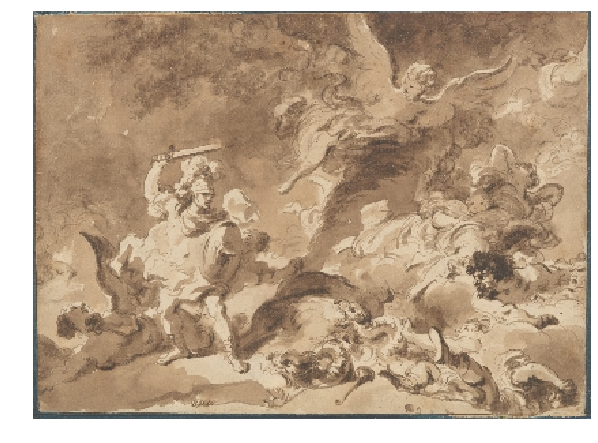

culture::french
tag::angels
tag::soldiers
tag::swords


In [273]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()
for li in annotations_frame.iloc[idx, 1].split():
    print(label_embeddings.ix_to_label[int(li)])


In [274]:
labels_distances = []
for word in label_embeddings.vocab:
    lv = torch.tensor(label_embeddings.label_embeddings.wv.word_vec(word, use_norm=True), device="cuda").unsqueeze(0)
    dist = torch.nn.functional.cosine_similarity(out, lv)
    labels_distances.append((word, dist.item()))
    
sorted(labels_distances, key=lambda x:x[1], reverse=True)[:10]

[('culture::french', 0.5093252658843994),
 ('culture::italian', 0.45296791195869446),
 ('culture::central european', 0.3847760260105133),
 ('tag::nymphs', 0.34014442563056946),
 ('tag::diana', 0.3352823853492737),
 ('tag::women', 0.33201655745506287),
 ('tag::mythical creatures', 0.3151571750640869),
 ('tag::putti', 0.3121645152568817),
 ('culture::netherlandish', 0.30854159593582153),
 ('culture::dutch', 0.305317223072052)]

In [275]:
from numpy import linalg as LA
min_emb = 10000
max_emb = -10000
label_embeddings.label_embeddings.wv.init_sims()
for word in label_embeddings.vocab:
    max_emb = max(max_emb, np.max(label_embeddings.label_embeddings.wv.word_vec(word, use_norm=True)))
    min_emb = min(min_emb, np.min(label_embeddings.label_embeddings.wv.word_vec(word, use_norm=True)))
    
print(min_emb, max_emb)

-0.37917238 0.36789772


In [276]:
labels = np.zeros((2, 20))
label_idxs = [[3, 4, 7], [1, 3, 5]]
labels[0][label_idxs[0]] = 1
labels[1][label_idxs[1]] = 1
labels = torch.ByteTensor(labels)
torch.nonzero(labels)

tensor([[0, 3],
        [0, 4],
        [0, 7],
        [1, 1],
        [1, 3],
        [1, 5]])

In [277]:
torch.tensor([1, 2, 3])

tensor([1, 2, 3])